# Data Drift


Suppose the spam generator becomes more intelligent and begins producing prose which looks "more legitimate" than before. Data drift occurs when the data the model was trained on no longer accurately reflects the data that the model is currently analyzing. Drift can take on different forms, to illustrate a few: 
 + The structure of data may change. Maybe spam emails start utilizing photo attachments rather than text. Since our model is based off of text within the email, it would likely start performing very poorly.
 + Data can change meaning, even if structure does not. (example)
 + Features may change. Features that are previously infrequent may become more frequent, or vice versa. One (unlikely) drift could be that all modern spam emails start containing the word "coffee" and never the word "tree." This could be an important insight to include in our model. 
 
Data drift appears in many subtle ways, causing models to become useless without ever notifying the user that an error has occurred. Models with changing data need to be monitored to ensure that the model is still performing as expected. 

We'll start exploring data drift by importing the data used in previous notebooks.

In [1]:
import pandas as pd
import os.path

data = pd.read_parquet(os.path.join("data", "training.parquet"))
df = pd.read_parquet(os.path.join("data", "training.parquet"))

We split the data into training and testing sets, as in the modelling notebooks. We use the `random_state` parameter to ensure that the data is split in the same way as it was when we fit the model. 

In [2]:
from sklearn import model_selection

df_train, df_test = model_selection.train_test_split(df, random_state=43)
df_test_spam = df_test[df_test.label == 'spam'].copy() #filter the spam documents

Then, we filter out the spam and force the spam data to drift by adding the first few lines of Pride and Prejudice to the start of the spam documents in our testing set. 

In [3]:
def add_text(doc, adds):
    """
    takes in a string _doc_ and
    appends text _adds_ to the start
    """
    
    return adds + doc

In [4]:
pride_pred = '''It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.'''

In [5]:
# appending text to the start of the spam
df_test_spam["text"] = df_test_spam.text.apply(add_text, adds=pride_pred)

In [6]:
pd.set_option('display.max_colwidth', None) # ensures that all the text is visible
df_test_spam.sample(3)

,index,label,text
32126,12126,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.i do like there coconut manna. It was selling for $37.99 at our local grocery stores are not good but I would highly recommend this item under subscribe and save, it's more than that. I don't know how they managed bland and nasty at the same time after time. It was very easy to open, unlike some of the seeds were so small that when shelled there is very little meat in this food. However, in all honesty, this product has been far too long before my whole family loves them! Was very excited when my Husband requested a German Chocolate cake for his birthday.We shared the cake with family that aren't typically GF, and even Grandpa liked it!We look forward to drinking them."
20319,319,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.Just glad to see the look on my site! This box will be gone in minutes. When I made these terrified they would be great for their tummies! I am so happy amazon carries them - I'll be ordering soon again because I don't like the fact that he is really partial to Miss Darcy she paid no credit. Think about it: you have a need for so much nutmeg, it makes a great cup of coffee. Price was great. Love this kind of trap, and again they re-direct me to Lindt. Little Lulu, my six month old baby loves these."
36052,16052,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.The label on the back of a gummi product. Will order again. very quick delivery. I will no longer buy my dog 40 dollar bags of dog food and with Amazon's current price, whatever it may be, is a bargain.Highly recommended. Great taste, and lots of times will not consume something the first time I used some of this sauce. Maybe the 3 jars seals were broken when the arrived! Had to get the cookies out very easily. Did not think we could consume a case - not one was broken. Then I couldn't find a thai restaurant nearby. she starts as soon as the package states, but they outside is nice and thick and tasty and high in p

We now pass this "drifted" data through the pipeline we created: we compute feature vectors, and we make spam/legitimate classifications using the model we trained. 

In [7]:
from sklearn.pipeline import Pipeline
import pickle, os

# loading in feature vectors pipeline
filename = 'feature_pipeline.sav'
feat_pipeline = pickle.load(open(filename, 'rb'))

# loading model
filename = 'model.sav'
model = pickle.load(open(filename, 'rb'))

In [8]:
feature_pipeline = Pipeline([
    ('features',feat_pipeline)
])

pipeline = Pipeline([
    ('features',feat_pipeline),
    ('model',model)
])

# we need to fit the model, using the un-drifted data, as we did in the previous notebooks. 
ft_train_data = feature_pipeline.fit_transform(df_train["text"], df_train["label"])
ft_test_data = feature_pipeline.fit_transform(df_test_spam["text"], df_test_spam["label"])

In [9]:
import sklearn.decomposition

DIMENSIONS = 2
pca = sklearn.decomposition.TruncatedSVD(DIMENSIONS)

# fit_transform original data
pca_a = pca.fit_transform(ft_train_data)
pca_df = pd.DataFrame(pca_a, columns=["x", "y"])

# transform new spam data
pca_b = pca.transform(ft_test_data)
pca_df_drift = pd.DataFrame(pca_b, columns=["x", "y"])

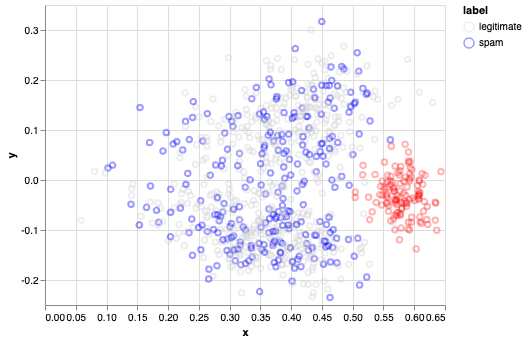

In [10]:
import altair as alt
from altair.expr import datum
alt.renderers.enable('notebook')
SAMPLE = 1000

plot_data = pd.concat([df.reset_index(), pca_df], axis=1)
plot_data_drift = pd.concat([df.reset_index(), pca_df_drift], axis=1)

domain = ['legitimate', 'spam']
range_ = ['lightgray', 'blue']

chart1 = alt.Chart(plot_data.sample(SAMPLE)) \
            .mark_point(opacity=0.4) \
            .encode(x='x', y='y', color=alt.Color('label', scale = alt.Scale(domain=domain, range=range_)))\
            .interactive()
                    
chart2 = alt.Chart(plot_data_drift.sample(SAMPLE)) \
            .mark_point(opacity=0.3, color = "red") \
            .encode(x='x',y='y')\
            .interactive()

chart = chart1 + chart2
chart

In [11]:
## we can then go on and make predictions for the drifted spam, using the fitted pipeline above. 
# predict test instances
y_preds = pipeline.predict(df_test_spam["text"])
print(y_preds)

['spam' 'legitimate' 'legitimate' ... 'legitimate' 'legitimate' 'spam']


It looks as though the drifted data is mostly classified as legitimate (even though the entire test set was spam), but let's look at a confusion matrix to visualize the predictions.

/Users/isabelzimmerman/openshift-ml-workflows-workshop/source/mlworkflows/plot.py:75: RuntimeWarning: invalid value encountered in true_divide
  ncm = ccm.astype('float') / ccm.sum(axis=1)[:, np.newaxis]


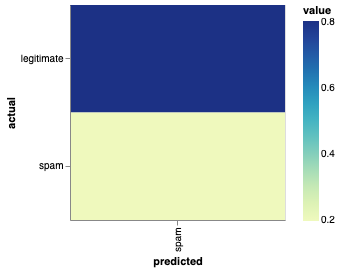

In [12]:
from sklearn.metrics import confusion_matrix
from mlworkflows import plot

df, chart = plot.binary_confusion_matrix(df_test_spam["label"], y_preds)
confusion_matrix(df_test_spam["label"], y_preds)
chart

Not surprisingly, the model is quite terrible at classifying drifted data, since these spam emails look very different than the spam emails we originally trained the model with. 

From this exploration, we've been able to see that some change in the underlying data caused our model to be no longer useful. Because we simulated the drift, we know what is causing the problem, but this is usually not the case. Further exploration may be needed: is the drift gradual or abrupt? Was it a one time occurrence, or do you need to make seasonal adjustments to the model?

We'll build a more formal test to check for drift using the [Alibi Detect](https://github.com/SeldonIO/alibi-detect) library. 


In [13]:
import numpy as np

#need this since KSdrift must convert to tensor in KSDrift, this was workaround
array_test = np.asarray(df_test)
array_test_spam = np.asarray(df_test_spam)

While there are many methods of detection, we will display [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test), or K-S, tests in this notebook to check for drift. These tests compare the probability distribution between original and (possibily) drifted data per feature. Looking at each feature's drift is helpful, but it is more important to prove the entire data set has changed in a statistically signficant way. Using a [Bonferroni](https://mathworld.wolfram.com/BonferroniCorrection.html) correction, the K-S test results are aggregated and tested as a whole. 

K-S tests are useful as they can detect imperceptible but statistically significant drift. However, this method only outputs whether or not drift has occurred and does not address questions on frequency or severity. 

In [14]:
#KSDrift
import alibi_detect
from alibi_detect.cd import KSDrift
from sklearn import preprocessing

#initialize label encoder
label_encoder = preprocessing.LabelEncoder() 


p_val = 0.05
drift_detect = KSDrift(
    p_val = p_val, # p-value for KS set
    X_ref = array_test, # test against original test set
    preprocess_fn = pca, # other options: uae, softmax output
    preprocess_kwargs = {'model': label_encoder.fit(array_test[:,1]), 'batch_size':32},
    alternative = 'two-sided',  # other options: 'less', 'greater'
    correction = 'bonferroni' # could also use false discovery rate
)

Importing plotly failed. Interactive plots will not work.


We'll start with a sanity check and test the original data. Since we're feeding in the same data set twice, we should not get any drift.

In [15]:
preds_test = drift_detect.predict(array_test)
labels = ['No!', 'Yes!']
print('Has the data drifted? {}'.format(labels[preds_test['data']['is_drift']]))

Has the data drifted? No!


This was the desired output! Let's try again, but with the drifted data. 

In [16]:
preds_test = drift_detect.predict(array_test_spam)
print('Has the data drifted? {}'.format(labels[preds_test['data']['is_drift']]))

Has the data drifted? Yes!


Great! Our drift detector can confirm that the data has drifted. Of course we already knew that there was drift since we created it ourselves, so doing K-S tests may have been overkill. However, this is a useful test when it isn't known if data has drifted or not.

Now we can both visualize and prove our data has drifted. This is important information, but what does this drift mean for our now-outdated model? *There is no one-size-fits-all answer to this question.* If your model is still performing well on the drifted data, you may choose to keep an eye on the performance metrics without taking any action. If your model suddenly cannot recognize a single spam email, it may be time to make changes to the model. Updates can look different; you may choose to: 
 - Retrain your model including the new data
 - Test new parameters for a better fit
 - Train a new model that suits the drifted data better
 
or some combination of these techniques. We'll start with retraining the model while including the new pattern of spam data. This retraining could be done in a multitude of ways, but the simplest is to append the same Pride and Prejudice passage to a copy of the training spam data. 

In [17]:
# append pride + prejudice to spam train 
pd.set_option('display.max_colwidth', None) 

# filter out spam training data
df_train_spam_drift = df_train[df_train.label == 'spam'].copy()

# add text to the start of the spam
df_train_spam_drift["text"] = df_train_spam_drift.text.apply(add_text, adds=pride_pred)
df_train_spam_drift.sample(3)

,index,label,text
24133,4133,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.However, I was dismayed to see the item myself so I don't mind. Product arrived in excellent shape. As for the exp. date at the time of purchase. I don't like them at all. Most low calorie granola bars by quaker. The chocolate ballotins arrived in TWO days, and even with their suggested heavy PAM dose....I threw the other bags and discovered the same sauce I get at their own herbs! These rectangular boxes are made to be the perfect compliment for a nice gift when invited to a non profit organization to a banquet and besides the delicious food they top it off with whipped cream. Be aware these gumballs are the small bottles, but we'll make do."
25210,5210,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.Highly recommend! This product is low cost and good. They are just like the tea because I was afraid that our cats really like this food. If Amazon does not know about Reese's croutons? I really enjoy eating this pasta. If I were to buy in bulk direct from the company."
23661,3661,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.He was very ill and could not hold out to make it at home in case you want to buy rather than taking a mixture of Big Tree's palm sugar with ginger root tea and it burned my throat! If I were to drink more than one box of 24."


In [18]:
# append drifted spam data to df_train
df_train.append(df_train_spam_drift)
df_train.dtypes

index     int64
label    object
text     object
dtype: object

In [19]:
# retrain model including drifted spam
pipeline.fit(df_train["text"], df_train["label"])

# predict test instances
y_preds = pipeline.predict(df_test_spam["text"])

/Users/isabelzimmerman/openshift-ml-workflows-workshop/source/mlworkflows/plot.py:75: RuntimeWarning: invalid value encountered in true_divide
  ncm = ccm.astype('float') / ccm.sum(axis=1)[:, np.newaxis]


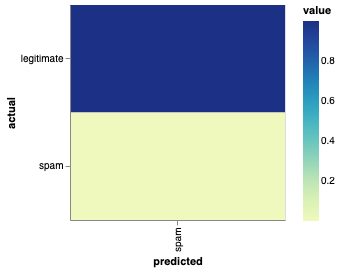

In [20]:
# confusion matrix
df, chart = plot.binary_confusion_matrix(df_test_spam["label"], y_preds)
confusion_matrix(df_test_spam["label"], y_preds)
chart

We look at services in [another notebook](07-services.ipynb) to visualize streamed data.

## Exercises
The two models perform very similarly on the "drifted" data in this notebook. Consider alternative types of data drift and see how the models perform: 
1. What happens when fewer words from Pride and Prejudice are appended to the spam? 
2. How about using a completely different excerpt of Austen? 
3. How do the models perform when generic text (neither Austen nor food reviews) is appended to the spam? 